Notebook specific for others ( sockets + lighting ) model improvement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
from skforecast.model_selection import select_features

import plotly
import plotly.graph_objects as go


from astral import LocationInfo
from astral.sun import sun


In [2]:
from custom_utils import *

In [3]:
def get_raw_data():
    data_path = "./../data/"
    file_name = "data.csv"
    data = pd.read_csv(data_path + file_name)
    data = first_preprocess(data, data_path)
    return data

In [4]:
data = get_raw_data()
data.head()

d:\RA_work\timeseries_data\notebooks\custom_utils.py:110: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data[column] = data[column].interpolate(method="linear", limit_direction="both")


,space_heating,hot_water,sockets,lighting,bld_engcons,car_chargers,weekend,bank_holiday,day_of_month,year,...,month_spline_9,month_spline_10,month_spline_11,day_of_week_spline_0,day_of_week_spline_1,day_of_week_spline_2,day_of_week_spline_3,day_of_week_spline_4,day_of_week_spline_5,day_of_week_spline_6
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3.425193,0.000000,0.049433,0.154873,3.629499,0.0,0,1,1,2021,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.666667
2021-01-01 01:00:00+00:00,4.012907,0.000000,0.047753,0.154846,4.215506,0.0,0,1,1,2021,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.666667
2021-01-01 02:00:00+00:00,5.342417,0.444782,0.051869,0.154997,5.994066,0.0,0,1,1,2021,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.666667
2021-01-01 03:00:00+00:00,5.756598,0.000000,0.043028,0.154626,5.954252,0.0,0,1,1,2021,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.666667
2021-01-01 04:00:00+00:00,5.415492,0.000000,0.050306,0.154498,5.620296,0.0,0,1,1,2021,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.666667


In [5]:
data.columns

Index(['space_heating', 'hot_water', 'sockets', 'lighting', 'bld_engcons',
       'car_chargers', 'weekend', 'bank_holiday', 'day_of_month', 'year',
       'forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_visibility',
       'week_of_year', 'sine_hour', 'cos_hour', 'sine_month', 'cos_month',
       'sine_day_of_week', 'cos_day_of_week', 'sine_forecast_winddirection',
       'cos_forecast_winddirection', 'hour_spline_0', 'hour_spline_1',
       'hour_spline_2', 'hour_spline_3', 'hour_spline_4', 'hour_spline_5',
       'hour_spline_6', 'hour_spline_7', 'hour_spline_8', 'hour_spline_9',
       'hour_spline_10', 'hour_spline_11', 'hour_spline_12', 'hour_spline_13',
       'hour_spline_14', 'hour_spline_15', 'hour_spline_16', 'hour_spline_17',
       'hour_spline_18', 'hour_spline_19', 'hour_spline_20', 'hour_spline_21',
       'hour_spline_22', 'hour_spline_23', 'mont

In [6]:
def get_year_split(df, year, col_name):
    df = df[[col_name]]
    df.loc[:, "year"] = df.index.year
    year_df = df[df["year"] == year]
    year_df = year_df.rename(columns={f"{col_name}": f"{col_name}_{year}"})
    year_df.loc[:, "time"] = year_df.index.time
    year_df.loc[:, "month"] = year_df.index.month
    year_df.loc[:, "day"] = year_df.index.day

    year_df = year_df.drop(columns="year")
    return year_df

In [7]:
import warnings; warnings.filterwarnings("ignore")
from datetime import datetime

In [9]:
for col in ["sockets", "lighting"]:
    year_2021 = get_year_split(data, 2021, col).reset_index(drop=1)
    year_2022 = get_year_split(data, 2022, col).reset_index(drop=1)
    year_2023 = get_year_split(data, 2023, col).reset_index(drop=1)

    common_cols = ["time", "day", "month"]
    tmp1 = year_2021.merge(year_2022, on=common_cols, how="left").merge(year_2023, on=common_cols, how="left")

    def get_key_time(row):
        return datetime(
            year=2000,
            day=row["day"],
            month=row["month"],
            second=row["time"].second,
            hour=row["time"].hour,
            minute=row["time"].minute
        )
    
    tmp1.loc[:, "keytime"] = tmp1.apply(get_key_time, axis=1)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tmp1["keytime"].to_numpy(), y=tmp1[f"{col}_2021"].to_numpy(),
                        mode='lines+markers',
                        name=f'{col}_2021'))
    fig.add_trace(go.Scatter(x=tmp1["keytime"].to_numpy(), y=tmp1[f"{col}_2022"].to_numpy(),
                        mode='lines+markers',
                        name=f'{col}_2022'))
    fig.add_trace(go.Scatter(x=tmp1["keytime"].to_numpy(), y=tmp1[f"{col}_2023"].to_numpy(),
                        mode='lines+markers',
                        name=f'{col}_2023'))

    fig.update_layout(title_text=f"Year on Year data in {col}")
    fig.show()

In [ ]:
exo_columns = ['forecast_temperature', 'forecast_feelslike', 
               'forecast_weathertype',
       # 'forecast_windspeed', 
       'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_visibility', 
       # 'daylight_hours',  
       # 'is_daylight', 
       'sine_hour',
       'cos_hour', 
       'sine_month', 'cos_month', 
       'sine_day_of_week', 'cos_day_of_week', 
       'sine_forecast_winddirection',
       'cos_forecast_winddirection', 
       # 'sine_sunrise_hour', 'cos_sunrise_hour', 'sine_sunset_hour', 'cos_sunset_hour'
       "week_of_year",
       'hour_spline_0', 'hour_spline_1',
       'hour_spline_2', 'hour_spline_3', 'hour_spline_4', 'hour_spline_5',
       'hour_spline_6', 'hour_spline_7', 'hour_spline_8', 'hour_spline_9',
       'hour_spline_10', 'hour_spline_11', 'hour_spline_12', 'hour_spline_13',
       'hour_spline_14', 'hour_spline_15', 'hour_spline_16', 'hour_spline_17',
       'hour_spline_18', 'hour_spline_19', 'hour_spline_20', 'hour_spline_21',
       'hour_spline_22', 'hour_spline_23', 'month_spline_0', 'month_spline_1',
       'month_spline_2', 'month_spline_3', 'month_spline_4', 'month_spline_5',
       'month_spline_6', 'month_spline_7', 'month_spline_8', 'month_spline_9',
       'month_spline_10', 'month_spline_11', 'day_of_week_spline_0',
       'day_of_week_spline_1', 'day_of_week_spline_2', 'day_of_week_spline_3',
       'day_of_week_spline_4', 'day_of_week_spline_5', 'day_of_week_spline_6'
       ]
endo_columns = ['weekend',] # "month", "day_of_week" ] # 'bank_holiday'] # 'day_of_month', 'year']
target_column = ["y"]
column_name = exo_columns + endo_columns  + target_column
test_date = '2023-01-01'

# transform the data
others_data = data.copy()
# "hot_water", "sockets", "lighting"
others_data["others"] = others_data["sockets"] + others_data["lighting"] # + others_data["hot_water"]
others_data = others_data.rename(columns={"others": "y"})
# others_data["y"] = others_data["others"].shift(-1)
# others_data = others_data.dropna(axis=0)

others_data_scaler, others_transformed_data = create_std_scaler(others_data, column_name[:-1])
others_target_scaler, others_transformed_target_data = create_std_scaler(others_data, column_name[-1])

others_transformed_data = pd.merge(others_transformed_data, others_transformed_target_data,
                               left_index=True,
                               right_index=True)

# # Training and testing data for comms and services
others_train_data = others_transformed_data[others_transformed_data.index < test_date][column_name]
others_test_data = others_transformed_data[others_transformed_data.index >= test_date][column_name]
# train_data.shape, test_data.shape
# adding baseline minimum of y
# others_data.loc[others_data["y"] <= 0, "y"] = others_data[others_data["y"] > 0]["y"].min()

# others_train_data = others_data[others_data.index < test_date][column_name]
# others_test_data = others_data[others_data.index >= test_date][column_name]
others_train_data.shape, others_test_data.shape

In [ ]:
others_main_data = pd.concat([others_train_data, others_test_data], axis=0)
others_main_data.shape

In [ ]:
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(n_estimators=500, criterion="squared_error", max_depth=16, max_features="sqrt"),
    # regressor=LinearRegression(),
    lags=2
)

# feature selection
regressor = LGBMRegressor(n_estimators=500, max_depth=5, random_state=15926, verbose=-1)
selector = RFECV(
    estimator=regressor, step=1, cv=3, min_features_to_select=10, n_jobs=-1
)
selected_autoreg, selected_exog = select_features(
   forecaster         = forecaster,
   selector           = selector,
   select_only        = "exog", 
   y                  = others_train_data['y'],
   exog               = others_train_data[exo_columns + endo_columns],
   subsample          = 0.5,
   verbose            = True
)

In [ ]:
forecaster.fit(
    y=others_train_data["y"],
    exog=others_train_data[selected_exog]
)

In [ ]:
def custom_metric(y_true, y_pred):
    '''
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    '''
    return calculate_smape(actual=y_true, predicted=y_pred)

In [ ]:
def plot_predictions(plot_data, title_text):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["y"].to_numpy(),
                        mode='lines+markers',
                        name='actual'))
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["pred"].to_numpy(),
                        mode='lines+markers',
                        name='predictions'))
    fig.update_layout(title_text=title_text)
    fig.show()

In [ ]:
metric, others_predictions_training = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = others_train_data['y'],
    exog               = others_train_data[selected_exog],
    steps              = 1,
    metric             = custom_metric,
    initial_train_size = None,
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

print(f"Backtest error: {metric:.2f}")
others_predictions_training.head()

In [ ]:
others_predictions_training["y"] = others_train_data["y"]
others_predictions_training = others_predictions_training.reset_index(drop=0)
others_predictions_training = others_predictions_training.rename(columns={"index": "time"})
others_predictions_training[["pred", "y"]] = others_target_scaler.inverse_transform(others_predictions_training[["pred", "y"]])
others_predictions_training.head()

In [ ]:
plot_predictions(others_predictions_training, title_text="Others Training data")

In [ ]:
metric, others_predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = others_main_data['y'],
    exog               = others_main_data[selected_exog],
    steps              = 1,
    metric             = custom_metric,
    initial_train_size = others_main_data[others_main_data.index < "2023-01-01"].shape[0],
    fixed_train_size   = True,
    refit              = 1000,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

print(f"Backtest error: {metric:.2f}")
others_predictions.head()

In [ ]:
others_predictions["y"] = others_main_data[others_main_data.index >= "2023-01-01"]["y"]
others_predictions = others_predictions.reset_index(drop=0)
others_predictions = others_predictions.rename(columns={"index": "time"})
others_predictions[["pred", "y"]] = others_target_scaler.inverse_transform(others_predictions[["pred", "y"]])
others_predictions.head()

In [ ]:
plot_predictions(others_predictions, title_text="Others Test data")

In [ ]:
cal_metrics(others_predictions["pred"].to_numpy(), others_predictions["y"].to_numpy())

In [ ]:
cal_metrics(others_predictions_training["pred"].to_numpy(), others_predictions_training["y"].to_numpy())

In [ ]:
tmp_data = pd.concat([others_predictions_training, others_predictions], axis=0)
tmp_data = tmp_data.drop(columns=["y"], axis=1)

# tmp_data1 = others_main_data[others_main_data.index < '2021-01-01 06:00:00+00:00'][["y"]].reset_index(drop=0)
# tmp_data1[["y"]] = others_target_scaler.inverse_transform(tmp_data1[["y"]])

tmp_data1 = tmp_data.rename(columns={"y": "pred", "datetime": "time"})
# tmp_data = pd.concat([tmp_data1, tmp_data], axis=0)
tmp_data = tmp_data.set_index("time")
tmp_data = tmp_data.rename(columns={"pred": "others_predictions"})

tmp_data.to_csv("others_pred.csv", index=True)
tmp_data.shape

In [ ]:
feat_importances = pd.Series(forecaster.regressor.feature_importances_, index=forecaster.regressor.feature_names_in_)
feat_importances.sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

#### previous results without spline transformations
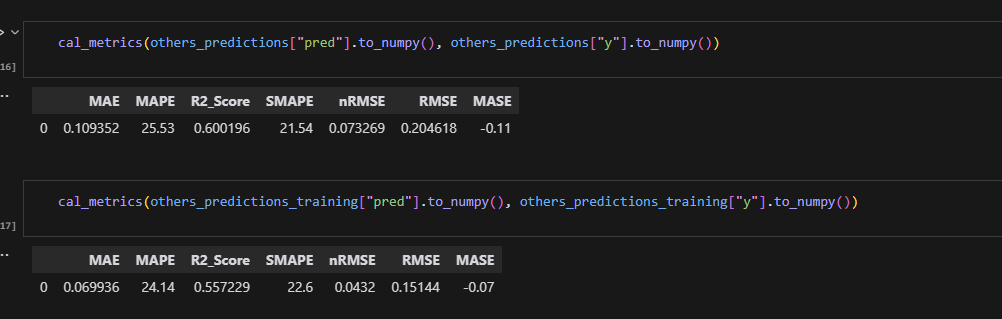